In [1]:
import numpy as np
import pandas as pd

data=pd.read_csv("F:\Tutorials\Certified program in MACHINE LEARNING and ARTIFICIAL INTELLIGENCE\Assignments\project\dataset\data.csv",encoding='unicode_escape')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [2]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5836 non-null   object
 1   Sentiment  5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


In [3]:
#labeling target variable
dict_label= {'positive': 0, 'neutral': 0 , 'negative': 1}
data.Sentiment = data.Sentiment.map(dict_label)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [4]:
data.Sentiment.value_counts()

0    4976
1     860
Name: Sentiment, dtype: int64

In [5]:
4976//860

5

## Create the dataframe to be augmented 

In [6]:
dfX=data[data["Sentiment"]==1].reset_index(drop=True)
dfX.head()

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
1,Shell's $70 Billion BG Deal Meets Shareholder ...,1
2,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,1
3,$SAP Q1 disappoints as #software licenses down...,1
4,$AAPL afternoon selloff as usual will be bruta...,1


## Data Augmentation by Synonym Replacement 

In [7]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random 

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
#print(stop_words)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [8]:

dfX_Aug=[]
for k in range(len(dfX)):
    trial_sent = dfX.Sentence[k]
    for n in range(6):
        txt= synonym_replacement(trial_sent,n)
        dfX_Aug.append(txt)

In [9]:
dfXAugmented=pd.DataFrame(dfX_Aug,columns=['Sentence'])
dfXAugmented['Sentiment'] = 1
dfXAugmented.head(10)

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
1,"$ESI on lows, down $1.50 to $2.50 BK a literal...",1
2,"$ESI on lows, down $1.50 to $2.50 atomic numbe...",1
3,"$ESI on lows, down $1.50 to $2.50 atomic numbe...",1
4,"$ESI on lows, down $1.50 to $2.50 berkelium a ...",1
5,"$ESI on lows, down $1.50 to $2.50 atomic numbe...",1
6,Shell's $70 Billion BG Deal Meets Shareholder ...,1
7,Shell's $70 Billion BG Deal fulfill Shareholde...,1
8,Shell's $70 Billion BG sell fill Shareholder S...,1
9,Shell's $70 zillion BG manage Meets Shareholde...,1


In [10]:
df1=data[data["Sentiment"]==0].reset_index(drop=True)
df2=dfXAugmented
frames = [df1, df2]
  
X = pd.concat(frames)
display(X )

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"For the last quarter of 2010 , Componenta 's n...",0
2,According to the Finnish-Russian Chamber of Co...,0
3,The Swedish buyout firm has sold its remaining...,0
4,$SPY wouldn't be surprised to see a green close,0
...,...,...
5155,RISING costs have forced packaging producer Hu...,1
5156,RISING costs have forced package producer Huht...,1
5157,RISING costs have forced packaging manufacture...,1
5158,RISING costs have forced packaging producer Hu...,1


In [11]:
X .Sentiment.value_counts()

1    5160
0    4976
Name: Sentiment, dtype: int64

## Split to train and test data 

In [12]:
from sklearn.model_selection import train_test_split
XTrain,XTest=train_test_split(X,test_size=0.2,random_state=42)

# Data Preprocessing

In [13]:
from keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer=text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(XTrain.Sentence))
# Get our training data word index
word_index = tokenizer.word_index
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(XTrain.Sentence)
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


print("\nPadded training shape:", train_padded.shape)



Padded training shape: (8108, 58)


In [14]:
test_sequences = tokenizer.texts_to_sequences(XTest.Sentence)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("\nPadded testing shape:",test_padded.shape)



Padded testing shape: (2028, 58)


In [15]:
for x, y in zip(XTest.Sentence, test_padded):
  print('{} -> {}'.format(x, y))

print("\nWord index (for reference):", word_index)

The EU Commission order earlier it had fined ThyssenKrupp , United Technologies Corp 's Otis , Schindler AG and Kone Oyj a total of 992.3 mln eur for alleged cartel activity in the lift market going book binding twelve years . -> [  1 206 119  31 144 794 312  11   5 776  55   6 109   2  24  41   7   8
   3   1  70 365 484   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
Atria will also buy the shares of Kauhajoen Teurastamokiinteistot Oy (Kauhajoki slaughterhouse property)from Itikka Co-operative . -> [854  16  95 260   1  75   2 297   9  42   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
The issue of corporeal combat injury grammatical case quadruple in 2000-2006 . -> [  1 430   2   3  72   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   

### Create an RNN model 

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SimpleRNN,Dropout

model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=128))
model.add(SimpleRNN(70))
model.add(Dropout(0.5))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1598464   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 70)                13930     
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1420      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,613,835
Trainable params: 1,613,835
Non-trainable params: 0
______________________________________________

In [18]:
X_train,y_train=train_padded,XTrain.Sentiment
X_test,y_test=test_padded,XTest.Sentiment

In [19]:
history=model.fit(X_train,y_train,batch_size=128,epochs=20,verbose=2,validation_data=(X_test,y_test ))

Epoch 1/20
64/64 - 3s - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6424 - val_accuracy: 0.6593
Epoch 2/20
64/64 - 3s - loss: 0.6025 - accuracy: 0.6984 - val_loss: 0.5530 - val_accuracy: 0.7441
Epoch 3/20
64/64 - 3s - loss: 0.5681 - accuracy: 0.7377 - val_loss: 0.5146 - val_accuracy: 0.7692
Epoch 4/20
64/64 - 3s - loss: 0.5121 - accuracy: 0.7902 - val_loss: 0.5954 - val_accuracy: 0.7051
Epoch 5/20
64/64 - 3s - loss: 0.5364 - accuracy: 0.7721 - val_loss: 0.5141 - val_accuracy: 0.7692
Epoch 6/20
64/64 - 3s - loss: 0.4479 - accuracy: 0.8272 - val_loss: 0.5280 - val_accuracy: 0.7579
Epoch 7/20
64/64 - 3s - loss: 0.4362 - accuracy: 0.8319 - val_loss: 0.5238 - val_accuracy: 0.7525
Epoch 8/20
64/64 - 3s - loss: 0.4393 - accuracy: 0.8246 - val_loss: 0.5147 - val_accuracy: 0.7712
Epoch 9/20
64/64 - 3s - loss: 0.4028 - accuracy: 0.8423 - val_loss: 0.4999 - val_accuracy: 0.7806
Epoch 10/20
64/64 - 3s - loss: 0.3949 - accuracy: 0.8483 - val_loss: 0.5054 - val_accuracy: 0.7840
Epoch 11/20
64/64 -

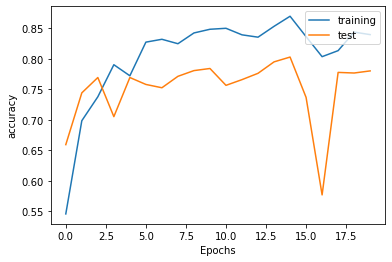

In [20]:
import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history.history[metrics])
plt.plot(history.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()
     